## About this Project

In this project, you will implement a simple Convolutional Neural Network that can recognize digits using [PyTorch](https://pytorch.org/).

<h3>Evaluation</h3>

<p><strong>This project must be successfully completed and submitted in order to receive credit for this course. Your score on this project will be included in your final grade calculation.</strong><p>
    
<p>You are expected to write code where you see <em># YOUR CODE HERE</em> within the cells of this notebook. Not all cells will be graded; code input cells followed by cells marked with <em>#Autograder test cell</em> will be graded. Upon submitting your work, the code you write at these designated positions will be assessed using an "autograder" that will run all test cells to assess your code. You will receive feedback from the autograder that will identify any errors in your code. Use this feedback to improve your code if you need to resubmit. Be sure not to change the names of any provided functions, classes, or variables within the existing code cells, as this will interfere with the autograder. Also, remember to execute all code cells sequentially, not just those you’ve edited, to ensure your code runs properly.</p>
    
<p>You can resubmit your work as many times as necessary before the submission deadline. If you experience difficulty or have questions about this exercise, use the Q&A discussion board to engage with your peers or seek assistance from the instructor.<p>

<p>Before starting your work, please review <a href="https://s3.amazonaws.com/ecornell/global/eCornellPlagiarismPolicy.pdf">eCornell's policy regarding plagiarism</a> (the presentation of someone else's work as your own without source credit).</p>

<h3>Submit Code for Autograder Feedback</h3>

<p>Once you have completed your work on this notebook, you will submit your code for autograder review. Follow these steps:</p>

<ol>
  <li><strong>Save your notebook.</strong></li>
  <li><strong>Mark as Completed —</strong> In the blue menu bar along the top of this code exercise window, you’ll see a menu item called <strong>Education</strong>. In the <strong>Education</strong> menu, click <strong>Mark as Completed</strong> to submit your code for autograder/instructor review. This process will take a moment and a progress bar will show you the status of your submission.</li>
	<li><strong>Review your results —</strong> Once your work is marked as complete, the results of the autograder will automatically be presented in a new tab within the code exercise window. You can click on the assessment name in this feedback window to see more details regarding specific feedback/errors in your code submission.</li>
  <li><strong>Repeat, if necessary —</strong> The Jupyter notebook will always remain accessible in the first tabbed window of the exercise. To reattempt the work, you will first need to click <strong>Mark as Uncompleted</strong> in the <strong>Education</strong> menu and then proceed to make edits to the notebook. Once you are ready to resubmit, follow steps one through three. You can repeat this procedure as many times as necessary.</li>

<p>You can also download a copy of this notebook in multiple formats using the <strong>Download as</strong> option in the <strong>File</strong> menu above.</p>

<h2>Getting Started</h2>
<h3>Python Initialization</h3> 

Please run the following code to initialize your Python kernel. You should be running a version of Python 3.x. </p>

In [1]:
%load_ext autoreload

In [2]:
%%capture
from tqdm import tqdm_notebook as tqdm
tqdm().pandas()

In [3]:
%autoreload 2
# First off, import some packages
import torch
import torch.nn as nn
from torch.nn import functional as F

from torchvision import datasets, transforms
import torchvision

import matplotlib.pyplot as plt
from helper import *

import numpy as np
%matplotlib inline
print('You\'re running python %s' % sys.version.split(' ')[0])

# Seed the random number generator
torch.manual_seed(1)
torch.cuda.manual_seed(1)

# Check whether you have a gpu
# If you have a gpu, model training will be done on gpu
# which is significantly faster than training on cpu
gpu_available = torch.cuda.is_available()
print ("GPU is available:",gpu_available)

You're running python 3.6.8
GPU is available: True


## Convolutional Neural Network

### Part One: Loading the Dataset and Setting up Dataloader

We will be using a well-known public dataset called [MNIST](https://en.wikipedia.org/wiki/MNIST_database), which consists of 60,000 training and 10,000 test black and white images of handwritten digits with labels. The MNIST data has been widely used in the Machine Learning research community to develop image processing models.

Using Pytorch, we download the dataset locally, and wrap it up in a "dataloader". The models will iterate on batches in the dataloaders.

In [4]:
# Setup the training set and test set
trainset = datasets.MNIST(root='.', train=True, download=True, transform=transforms.ToTensor())
testset = datasets.MNIST(root='.', train=False, download=True, transform=transforms.ToTensor())

# Setting up dataloader
# A dataloader stacks small batches of images (of 512 images in our case) into Tensors for easier training and evaluation
trainloader = torch.utils.data.DataLoader(trainset, shuffle=True, drop_last=True, batch_size=512, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, shuffle=True, drop_last=False, batch_size=512, num_workers=2)

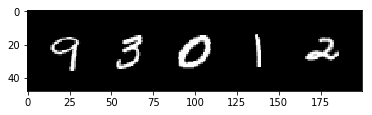

In [5]:
# Visualize the data
# The following line gets us small batch of data
# X is a tensor of size (512, 1, 28, 28) that contains a batch of images
# y is a tensor of size (512) that contains the labels in X
X, y = iter(trainloader).next()

def visualize_data(X):
    img_grid = torchvision.utils.make_grid(X[:5], padding=10)
    img_grid = img_grid.numpy()
    plt.imshow(np.transpose(img_grid, (1,2,0)), interpolation='nearest')
    return

visualize_data(X)

### Part Two: Define a Convolutional Neural Network [Partially Graded]

#### Define a Building Block of a CNN

A Convolutional Neural Network is made of multiple convolutional filters/kernels in a "block" that comprises the tunable weight parameters between a pair of layers. We create a class `Block` to hold all the parameters and define a `forward` function for forward propagation.

In [6]:
class Block(nn.Module):
    def __init__(self, in_channel, out_channel, kernel_size=3, stride=1):
        super(Block, self).__init__()
        
        self.in_channel = in_channel
        self.out_channel = out_channel
        self.kernel_size = kernel_size
        self.stride = stride
        
        # This block contains a convolutional layer
        # then a batch normalization layer
        
        self.conv = nn.Conv2d(in_channel, out_channel, kernel_size, stride)
        self.bn = nn.BatchNorm2d(out_channel)
        return
    
    def forward(self, x):
        # passes the input image through a convolutional layer
        # followed by a batch normalization layer and relu transition
        out = F.relu(self.bn(self.conv(x)))
        return out

In [7]:
# Create a block that is made up of 10 filters size 3x3 and stride 1

# The block takes in a image of 1 channel
Block1 = Block(1, 10, 3, 1)
out = Block1(X)

# After passing our image through block 1
# we get the following tensor
print(out.shape)

torch.Size([512, 10, 26, 26])


#### Build a CNN using the `Block` class [Graded]

In this section, you will build a Convolutional Neural Network in **`ConvNet`** that consists of 4 CNN blocks, an average pooling layer and a fully connected layer **in this order**. We have created the first block for you. What you need to do is create the rest of the blocks based on the specification.  

You can see that `self.block1` is initialized with `Block()`. Below it are the specs for the other 3 blocks.

In other words, your solution should be 3 lines that initialize `self.block2`, `self.block3`, and `self.block4` where it says `# TODO`. You need to pass in the appropriate parameters to `Block(input_size, num_filters, kernel_size, stride)`. Note that the `input_size` of one layer is the `num_filters` of the previous layer.

Please do not change the name of the layers or else you risk breaking the autograder code!

In [8]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__() 
        # First block takes in the image of channel 1
        # Filter specification:
            # Num filters=16, kernel size 3, stride 1
        self.block1 = Block(1, 16, 3, 1)
        
        # TODO
        # Second block takes in the output of the first block
        # Filter specification:
            # Num filters=32, kernel size 3, stride 1
        self.block2 = Block(16, 32, 3, 1)
        
        # TODO
        # Third block takes in the output of the 2nd block
        # Filter specification:
            # Num filters=64, kernel size 3, stride 1
        self.block3 = Block(32, 64, 3, 1)
        
        # TODO
        # Third block takes in the output of the 3rd block
        # Filter specification:
            # Num filters=128, kernel size 3, stride 1
        self.block4 = Block(64, 128, 3, 1)
        
        # This is the average pooling layer
        # This is applied to the output of the last convolutional layer
        # Essentially, it averages feature maps spatially to a single number
        # For instance, if the output of the last conv layer is of size (128, 15, 4, 4)
        # the following layer will average the 4x4 array into a single number
        # so the output of applying this layer would have size (128, 15, 1, 1)
        # This operation vectorize the feature maps so that we can have a vector
        # that can be passed into a simple linear layer for classification
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        
        # Create a linear layer
        # the dataset has 10 classes
        # the model should output 10 belief values
        self.fc = nn.Linear(128, 10)
            
        #raise NotImplementedError()

        
    def forward(self, x):
        batch_size = x.size(0)
        out = self.block1(x)
        out = self.block2(out)
        out = self.block3(out)
        out = self.block4(out)
        
        # .squeeze() operation remove unnecessary dimension
        # i.e if X is of shape (128, 128, 1, 1)
        # X.unsqueeze() becomes (128, 128)
        
        out = self.avgpool(out).squeeze()
        out = self.fc(out)
        
        return out
    
        raise NotImplementedError()


In [9]:
# Create a model
model = ConvNet()

# Move the model to a cuda gpu
# Doing this step allows up to do training on gpu
# and gain significant speed up
if gpu_available:
    model = model.cuda()

In [10]:
def model_test1():
    
    model = ConvNet()
    
    if gpu_available:
        model = model.cuda()
    # check whether block2, 3, 4 are instances of block
    isblock2 = isinstance(model.block2, Block)
    isblock3 = isinstance(model.block3, Block)
    isblock4 = isinstance(model.block3, Block)
    return isblock2 and isblock3 and isblock4
    

def model_test2():
    model = ConvNet()
    
    if gpu_available:
        model = model.cuda()
    # Checking the specification for block 2
    
    # Check input channel
    in_channel_check = model.block2.in_channel == 16
    
    # Check the output channel
    out_channel_check = model.block2.out_channel == 32
    
    # Check the kernel size
    kernel_size_check = model.block2.kernel_size == 3
    
    # check the stride size
    stride_check = model.block2.stride == 1
    return in_channel_check and out_channel_check and kernel_size_check and stride_check

def model_test3():
    model = ConvNet()
    
    if gpu_available:
        model = model.cuda()
    # Checking the specification for block 3
    
    # Check input channel
    in_channel_check = model.block3.in_channel == 32
    
    # Check the output channel
    out_channel_check = model.block3.out_channel == 64
    
    # Check the kernel size
    kernel_size_check = model.block3.kernel_size == 3
    
    # check the stride size
    stride_check = model.block3.stride == 1
    return in_channel_check and out_channel_check and kernel_size_check and stride_check

def model_test4():
    model = ConvNet()
    
    if gpu_available:
        model = model.cuda()
    # Checking the specification for block 3
    
    # Check input channel
    in_channel_check = model.block4.in_channel == 64
    
    # Check the output channel
    out_channel_check = model.block4.out_channel == 128
    
    # Check the kernel size
    kernel_size_check = model.block4.kernel_size == 3
    
    # check the stride size
    stride_check = model.block4.stride == 1
    return in_channel_check and out_channel_check and kernel_size_check and stride_check


runtest(model_test1, 'model_test1')
runtest(model_test2, 'model_test2')
runtest(model_test3, 'model_test3')
runtest(model_test4, 'model_test4')

Running Test: model_test1 ... ✔ Passed!
Running Test: model_test2 ... ✔ Passed!
Running Test: model_test3 ... ✔ Passed!
Running Test: model_test4 ... ✔ Passed!


In [11]:
# Autograder Test Cell
# model_test1


In [12]:
# Autograder Test Cell
# model_test2


In [13]:
# Autograder Test Cell
# model_test3


In [14]:
# Autograder Test Cell
# model_test4


### Part Three: Define a Loss Function and Optimizer [Graded] 

You are going to define the loss function and the optimizer. You should familiarize yourself with looking up PyTorch documentation.

#### Loss function [Graded]
The loss function should be the **cross entropy loss**. You can also implement the loss function yourself but we strongly suggest you use PyTorch's implementation -- it should be one short call to a [library](https://pytorch.org/docs/stable/nn.html#loss-functions) loss function.

In [15]:
#TODO: Define the loss function
loss_fn = nn.CrossEntropyLoss()  # This criterion computes the cross entropy loss between input logits and target.

#raise NotImplementedError()


In [16]:
def loss_fn_test1():
    num_classes = 10 # Suppose we have 10 classes 
    num_examples = 5
    logits = torch.ones((num_examples, num_classes)) # Simulate model belief
    y=torch.zeros(num_examples).long();
    loss = loss_fn(logits, y) # calculate the loss
    
    # Check whether the loss is a scalar
    return loss.size() == torch.Size([])

def loss_fn_test2():
    num_classes = 10 # Suppose we have 10 classes 
    
    # simulate model belief
    # in this case, the model believes that each class is equally likely
    logits = torch.ones((1, num_classes)) 
    y=torch.zeros(1).long();
    loss = loss_fn(logits,y) # calculate the loss
    
    # if the model has equal belief for each class, namely, P(y|x) is uniform
    # the negative loglikelihood should be -log(1 /num_classes) = log(num_classes)
    return (loss.item() == torch.log(torch.Tensor([num_classes])).item())

def loss_fn_test3():
    
    num_classes = 10 # Suppose we have 10 classes
    num_examples = 5 
    
    # simulate model belief
    # in this case, the model believes that each class is equally likely
    logits = torch.rand((num_examples, num_classes)) 
    y=torch.zeros(num_examples).long();
    loss = loss_fn(logits, y)
    loss_grader = loss_fn_grader(logits, torch.zeros(num_examples).long())
    
    # Check whether your loss and our loss is almost the same
    return (torch.abs(loss - loss_grader)).item() < 1e-5


runtest(loss_fn_test1, 'loss_fn_test1')
runtest(loss_fn_test2, 'loss_fn_test2')
runtest(loss_fn_test3, 'loss_fn_test3')

Running Test: loss_fn_test1 ... ✔ Passed!
Running Test: loss_fn_test2 ... ✔ Passed!
Running Test: loss_fn_test3 ... ✔ Passed!


In [17]:
# Autograder Test Cell
# loss_fn_test1



In [18]:
# Autograder Test Cell
# loss_fn_test2


In [19]:
# Autograder Test Cell
# loss_fn_test3



#### Optimizer [Graded]
I the next cell, you will define an **SGD optimizer**. Again, you should just call one library function from [`torch.optim`](https://pytorch.org/docs/stable/optim.html). In addition to passing in the model parameters `model.parameters()`, please set `lr=0.1`.

In [20]:
#TODO: Define the optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)  # Package implementing various optimization algorithms.

#raise NotImplementedError()


In [21]:
def optimizer_test1():
    return isinstance(optimizer, torch.optim.SGD)

runtest(optimizer_test1, 'optimizer_test1')

Running Test: optimizer_test1 ... ✔ Passed!


In [22]:
# Autograder Test Cell
# optimizer_test1



### Part Four: Train the Network [Graded]

In this section, you are going to implement the **`train`** function. Please see the `#TODO`s in the code stub for specifications. Your solution should be one line for each todo (that is, 3 lines total). 

- `logits` is the output of a forward pass - to obtain them call `model` on the current mini-batch `X`.
- `loss` should be calculated with the loss function `loss_fn` (HINT: look at the tests above to see how the loss function is called).
- Finally, you need to back propagate by calling `loss.backward()` on the loss function.

In [23]:
def train(model, optimizer, loss_fn, trainloader):
    """
    Trains the model using the optimizer, loss function, and training data in trainloader.
    
    Input:
        model: ConvNet model
        optimizer: optimizer for the model
        loss_fn: loss function 
        trainloader: the dataloader
    
    Output:
        running_loss: the average loss of the network
    """
    
    # Set the model into train mode
    model.train()
    
    # Create a variable to keep track of the running loss
    running_loss = 0.0
    
    # iterate through trainloader
    # each iterate, you will get a batch of images X, and labels, y
    for i, (X, y) in enumerate(trainloader):
        
        if gpu_available:
            # Move the data to cuda gpu to accelerate training
            X, y = X.cuda(), y.cuda()
        
        # zero the parameter gradient
        optimizer.zero_grad()
        
        # TODO: Do a forward pass the get the logits
        logits = model(X)
        
        # TODO: Evaluate the loss
        loss = loss_fn(logits, y)
        
        # TODO: Do a backward pass by calling 
        # .backward()
        loss.backward()
        
        #raise NotImplementedError()
        
        # update the parameters
        optimizer.step()
        
        # update the loss
        running_loss = running_loss + loss.item()
        
    return running_loss / len(trainloader)

    raise NotImplementedError()


In [24]:
def train_test1():
    from copy import deepcopy
    
    
    model = ConvNet()
    if gpu_available:
        model = model.cuda()
    model2 = deepcopy(model)
    
    optimizer = create_optimizer(model)
    optimizer2 = create_optimizer(model2)
    
    # sample one batch of training examples
    X, y = iter(trainloader).next()
    
    # Create a dataset using the small batch
    small_set = torch.utils.data.TensorDataset(X, y)
    
    # create a dataloader for the small_set
    loader = torch.utils.data.DataLoader(small_set, batch_size=128)
    
    # run your train function twice
    # Essentially update the model twice
    loss = train(model, optimizer, loss_fn, loader)
    loss2 = train(model, optimizer, loss_fn, loader)
    
    # run our train function twice
    # update the model twice
    loss_grader = train_grader(model2, optimizer2, loss_fn, loader)
    loss_grader_2 = train_grader(model2, optimizer2, loss_fn, loader)
    
    # your losses and our losses should be too different
    return ((loss - loss_grader)**2 + (loss2 - loss_grader_2)**2) < 1e-5

runtest(train_test1, 'train_test1')

Running Test: train_test1 ... ✔ Passed!


In [25]:
# Autograder Test Cell
# train_test1



In [26]:
# The following code will train the model
# Running this cell should take about three minutes. A progress ber will display speed and duration of training.

num_epochs = 10

for epoch in tqdm(range(num_epochs)):
    running_loss = train(model, optimizer, loss_fn, trainloader)
    print('Running Loss for Epoch [{}/ {}]: {:.4f}'.format(epoch + 1, num_epochs, running_loss))

Running Loss for Epoch [1/ 10]: 1.6443
Running Loss for Epoch [2/ 10]: 0.8854
Running Loss for Epoch [3/ 10]: 0.4776
Running Loss for Epoch [4/ 10]: 0.2968
Running Loss for Epoch [5/ 10]: 0.2177
Running Loss for Epoch [6/ 10]: 0.1766
Running Loss for Epoch [7/ 10]: 0.1474
Running Loss for Epoch [8/ 10]: 0.1296
Running Loss for Epoch [9/ 10]: 0.1148
Running Loss for Epoch [10/ 10]: 0.1045



### Part Five: Test the network on the test data [Graded]

In this section, you will implement **`pred`** that takes in the output of the forward pass (the `logits`) and outputs its prediction. `logits` is a matrix of shape `(n, C)` where `C` is the number of labels (10 for MNIST -- number of digits). The prediction should be the `argmax` along the second axis (`dim=1`).

In [27]:
def pred(logits):
    """
    Calculates the predictions of the ConvNet using the logits.
    
    Input:
        logits: nxC output matrix of the network. n is the number of data points, C is the number of labels.
    
    Output:
        prediction: n-dimensional vector of predictions
    """

    # TODO Calculate the prediction based using torch.argmax
    prediction = torch.argmax(logits, dim=1)  # Indices of the first maximal value returned.
    
    return prediction

    raise NotImplementedError()


In [28]:
def pred_test1():
    
    # Generate some beliefs
    logits = torch.Tensor([[0, 1], [2, -1]])
    prediction = pred(logits)
    
    # the expected output should be [1, 0]
    expected_output = torch.LongTensor([1, 0])
    
    return torch.equal(prediction, expected_output)

runtest(pred_test1, 'pred_test1')

Running Test: pred_test1 ... ✔ Passed!


In [29]:
# Autograder Test Cell
# pred_test1


We trained the model above and now we can evaluate it using your `pred` function.

In [30]:
# the following code will use your pred function and evaluate the whole test set and print your model's accuracy

total = 0.0
correct = 0.0
model.eval()
with torch.no_grad():
    for X, y in testloader:
        if gpu_available:
            X, y = X.cuda(), y.cuda()
        logits = model(X)
        
        prediction = pred(logits) 
        total += X.size(0)
        correct += (prediction == y).sum().item()

print('Accuracy of the model: {:.4}%'.format(correct / total * 100))

Accuracy of the model: 97.56%


Prediction:  [8, 6, 4, 4, 6]


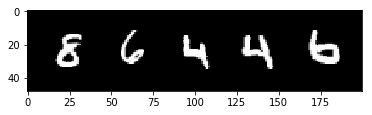

In [31]:
# Visualize some of the test images 
# and see their prediction

test_iterator = iter(testloader)
X_test, y_test = test_iterator.next()
X_test, y_test = X_test[:5], y_test[:5]
visualize_data(X_test)
model.eval()
with torch.no_grad():
    if gpu_available:
        X_test = X_test.cuda()
    logits = model(X_test)
    prediction = pred(logits)
print("Prediction: ", prediction.tolist())

### Tensorflow approach

We can train the same network on MNIST data in Tensorflow as well.

In [32]:
import tensorflow as tf
import math

In [33]:
def plot_imgs(images, labels=None):
    subplots_x = int(math.ceil(len(images) / 5))
    plt.figure(figsize=(10,2*subplots_x))
    for i in range(min(len(images), subplots_x*5)):
        plt.subplot(subplots_x,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i], cmap=plt.cm.binary)
        if labels is not None:
            plt.xlabel(labels[i])
    plt.show()

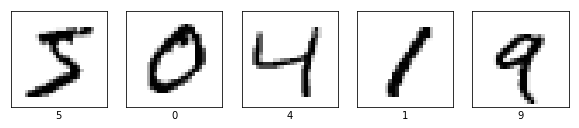

In [34]:
mnist = tf.keras.datasets.mnist
(x_train, y_train),(x_test, y_test) = mnist.load_data()
plot_imgs(x_train[:5], y_train[:5])

In [35]:
# Tensorflow downloads the images raw. We must normalize pixel values to be between 0 and 1
x_train, x_test = x_train / 255.0, x_test / 255.0

# Converting datasets of shape (num_points, 28, 28) to (num_points, 28, 28, 1)
x_train, x_test = x_train[..., np.newaxis], x_test[..., np.newaxis]

In [36]:
def block_tf(filters, kernel_size, stride):
    return [
        tf.keras.layers.Conv2D(filters, kernel_size, strides=(stride, stride), activation=None),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.ReLU()
    ]

## Define the network
model = tf.keras.models.Sequential([tf.keras.Input((28, 28, 1))] \
    + block_tf(16, 3, 1) \
    + block_tf(32, 3, 1) \
    + block_tf(64, 3, 1) \
    + block_tf(128, 3, 1) + [
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(10, activation=None)
])

model.summary()

## Define the loss function and optimizer
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.SGD(learning_rate=0.1)

model.compile(optimizer=optimizer, loss=loss_fn, metrics=['accuracy'])
model.fit(x_train, y_train, epochs=10)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 16)        160       
_________________________________________________________________
batch_normalization (BatchNo (None, 26, 26, 16)        64        
_________________________________________________________________
re_lu (ReLU)                 (None, 26, 26, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 32)        4640      
_________________________________________________________________
batch_normalization_1 (Batch (None, 24, 24, 32)        128       
_________________________________________________________________
re_lu_1 (ReLU)               (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 22, 22, 64)        1

Accuracy of the model: 98.4100%
Predictions on first 5 test images:


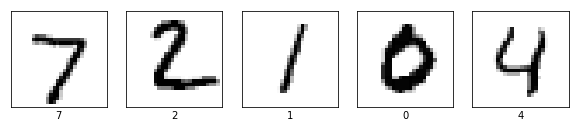

In [37]:
## Evaluate the network
logits = model(x_test)
predictions = tf.argmax(logits, axis=1)
print('Accuracy of the model: {:.4f}%'.format(tf.reduce_mean(tf.cast(predictions == y_test, tf.float32)).numpy() * 100))

print('Predictions on first 5 test images:')
plot_imgs(np.squeeze(x_test * 255, axis=-1)[:5], predictions.numpy()[:5])

#### Visualizing activations using Grad-CAM

With the [Grad-CAM algorithm](https://keras.io/examples/vision/grad_cam/), we can also visualize the pixels that "trigger" activations in the convolutional layers of the network. Here's an example where the algorithm returns a heatmap of activations in the last convolutional layer triggered by the image. We superimpose the heatmap on the image, but they might not align together exactly. "Hot" (yellow-red) regions in the heatmap indicate the pixels that triggered high magnitude activations, whereas "cold" (dark blue) regions indicate the pixels that did not significantly trigger activations.

Note: the heatmap might be shifted by a few pixels.

Play around with different images and check out the activated regions. Do you think the network is triggered by regions of images that we, as humans, consider the defining features for the corresponding classes? (For example, is the network triggered by the circle of the 0 image?)

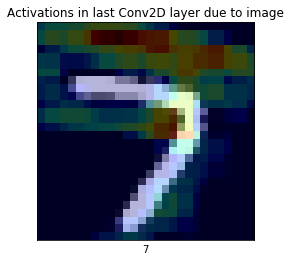

In [38]:
img_idx =17

img_array = x_test[img_idx][np.newaxis, ...]

logits = model(img_array)
predictions = tf.argmax(logits, axis=1)

last_conv_layer_name = [layer.name for layer in model.layers if isinstance(layer, tf.keras.layers.Conv2D)][-1]
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
display_gradcam(np.uint(255 * img_array)[0], heatmap, prediction=int(predictions.numpy()[0]))